In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
import pickle
import random

### Load in (correct) data

In [2]:
base_path = "C:/Users/Matt/Dropbox/SnowComp/"
path1 = base_path+"ModisSnowImagesT.npy"
path2 = base_path+"ModisSnowImagesA.npy"
path3 = base_path+"ModisSnowImages_subT.npy"
path4 = base_path+"ModisSnowImages_subA.npy"

train_dataT = np.load(path1)
train_dataA = np.load(path2)
# sub_dataT = np.load(path3) #be careful about memory, this is about 25-30 gigs ram
# sub_dataA = np.load(path4)

#load cell ids, note Ts are correct, As are actual daynums 
path_id = "C:/Users/Matt/Dropbox/SnowComp/cell_snow_idsT.pkl"
with open(path_id, 'rb') as handle:
    cell_ids = pickle.load( handle)
    
train_y = pd.read_csv("C:/Users/Matt/Documents/Python Scripts/SnowComp/dat/train_labels.csv")

In [3]:
#labels helpers and processing
def pivot_df(df, id_col, ignore_cols=None):
    if not ignore_cols:
        ignore_cols = []
    date_cols = [x for x in df.columns if x not in [id_col] + ignore_cols]
    dfs = []
    for day in date_cols:
        day_df = df[[id_col, day]].rename({day: 'snowpack'}, axis=1)
        day_df['date'] = day
        dfs.append(day_df)
    return pd.concat(dfs)

def daynum_gen(date_time):
    '''converts date time objects to filename'''
    date_time = datetime.fromisoformat(date_time)
    doy = date_time.timetuple().tm_yday
    year = date_time.year
    return str(year) + '{:03d}'.format(doy)

train_y = pivot_df(train_y, 'cell_id').dropna()
train_y['date']=train_y['date'].map(daynum_gen)

In [4]:
#sort train_y so it has correct order before stripping labels
train_y['idx'] = train_y['cell_id'] +"-"+train_y['date']
sorter = [idx +"-" +date for  idx, date  in cell_ids]
train_y = train_y.set_index('idx')
train_y = train_y.loc[sorter]

#combine Aqua and Terra DSs
dataset = np.concatenate((train_dataT[:,0:1,:,:],train_dataA[:,0:1,:,:]), axis = 1)
# dataset = np.concatenate((train_dataT,train_dataA), axis = 1)

# #delete problematic columns
# dataset = np.delete(dataset, 3, 1) 
# dataset = np.delete(dataset, 9, 1)

dataset= dataset/255

del train_dataT
del train_dataA

# Basic pytorch CNN

In [5]:
#@title Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

In [6]:
# Do categorical preds to start (change)
train_y['cat'] = train_y['snowpack'].apply(lambda x: 1 if x > 15 else 0)
# dataset.shape, train_y.shape

In [7]:
#@title Define simple CNN
# From: https://pytorch.org/tutorials/recipes/recipes/defining_a_neural_network.html
# Also used: https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html

START_D = 2
START_HW = 21

class Net(nn.Module):

    def _conv_calc(self, in_dim, pad, stride, k):
        out = int(np.floor((in_dim + 2 * pad - (k - 1) - 1) / stride + 1))
        return out

    def __init__(self, cdim1, cdim2,cdim3, kernel_sz, dropout,
                 ldim, print_dim = True):
        super(Net, self).__init__()
        
        #first layer
        self.conv1 = nn.Conv2d(2, cdim1, kernel_sz, 1)
        self.avgpool = nn.AvgPool2d(2, stride= 1)
        
        c1_dim = self._conv_calc(START_HW, 0, 1, kernel_sz)
        mp0_dim = self._conv_calc(c1_dim, 0, 1, 2)
        
        #second layer
        self.conv2 = nn.Conv2d(cdim1, cdim2, kernel_sz, 1)
        c2_dim = self._conv_calc(mp0_dim, 0, 1, kernel_sz)
        mp1_dim = self._conv_calc(c2_dim, 0, 1, 2)
        
        
        #third layer
        self.conv3 = nn.Conv2d(cdim2, cdim3, kernel_sz, 1)
        c3_dim = self._conv_calc(mp1_dim, 0, 1, kernel_sz)
        mp2_dim = self._conv_calc(c3_dim, 0, 1, 2)
        
        #fourth layer
        flattened_dim = cdim3 * mp2_dim * mp2_dim
        self.fc1 = nn.Linear(flattened_dim, ldim)
        self.fc2 = nn.Linear(ldim, 1)

        #extras
        self.dropout1 = nn.Dropout2d(dropout)
        self.dropout2 = nn.Dropout2d(dropout*2)
        self.BatchNorm1 = nn.BatchNorm2d(cdim1)
        self.BatchNorm3 = nn.BatchNorm2d(cdim3)
        
        if print_dim:
            print('c1 dim:', c1_dim)
            print('mp0 dim:', mp0_dim)
            print('c2 dim:', c2_dim)
            print('mp1 dim:', mp1_dim)
            print('c3 dim:', c3_dim)
            print('mp2 dim:', mp2_dim)
            print('flattened_dim',flattened_dim)
        
        
    def forward(self, x):
        #first layer
        x = self.conv1(x)
        x = F.relu(x)
        x = self.BatchNorm1(x)
        x = self.avgpool(x)
        
        #second layer
        x = self.dropout1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.avgpool(x)
        
        #third layer
        x = self.dropout2(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.BatchNorm3(x)
        x = self.avgpool(x)
        
        #fourth layer
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        
        output = self.fc2(x)
        return output

    




In [8]:
#@title Helpers to get predictions and accuracy
def predict(cnn, x, as_numpy=False):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    cnn.eval()
    x =x.type(torch.FloatTensor).to(device)
    output = cnn(x)
    if as_numpy:
        output = output.flatten().cpu().detach().numpy() #detach removes gradients (bad)
        
    cnn.train()
    return output.squeeze()

def get_accuracy(cnn, x, y):
#     y = torch.from_numpy(y).to(device)
    outputs = predict(cnn, x,as_numpy = False)
    
#     print(y.shape, outputs.shape)
    loss = ((y-outputs)**2).sum()
    return round(loss.item(), 6)



In [9]:
#@title Test run
# my_nn = Net(cdim1=8, cdim2=8, kernel_sz=3, dropout=0.25, ldim=8)
# optimizer = optim.Adam(my_nn.parameters(), lr=0.1)
# optimizer.zero_grad()

# test_im = torch.from_numpy(dataset[0]).reshape(1, 14, 21, 21)
# result = my_nn(test_im.type(torch.FloatTensor))
# result.shape


In [10]:
#@title split training and testing

mask = np.random.rand(len(dataset)) < 0.9
training_data = dataset[mask]
testing_data = dataset[~mask]
train_rows = len(training_data)
test_rows = len(testing_data)

In [11]:
#@title Get data loaders
# train_dataset = TensorDataset(torch.Tensor(dataset),
#                               torch.Tensor(train_y['snowpack']))
# train_loader = DataLoader(train_dataset, batch_size=64)

# mini_x, mini_y = np.array(dataset)[:2,], np.array(train_y['snowpack'])[:2,]

test_x, test_y = np.array(dataset)[~mask], np.array(train_y['snowpack'])[~mask]
test_x, test_y = torch.Tensor(test_x), torch.Tensor(test_y)
test_dataset = TensorDataset(test_x,test_y)
test_loader = DataLoader(test_dataset, batch_size = 200)

mini_x, mini_y = np.array(dataset)[mask], np.array(train_y['snowpack'])[mask]
mini_x, mini_y = torch.Tensor(mini_x), torch.Tensor(mini_y)

mini_dataset = TensorDataset(mini_x,
                              mini_y)
mini_loader = DataLoader(mini_dataset, batch_size=200)

In [12]:
#@title Setup net
cdim1=32; cdim2=24;cdim3 =16; kernel_sz=3; dropout=0.1; ldim=30
my_nn = Net(cdim1=cdim1, cdim2=cdim2,cdim3 =cdim3, kernel_sz=kernel_sz, dropout=dropout, ldim=ldim)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
my_nn.to(device)

optimizer = optim.Adam(my_nn.parameters(), lr=0.00005)
criterion = nn.MSELoss(reduction = 'sum')

writer = SummaryWriter('runs/cnn_full')
write_index = 0




c1 dim: 19
mp0 dim: 18
c2 dim: 16
mp1 dim: 15
c3 dim: 13
mp2 dim: 12
flattened_dim 2304


In [13]:
N_EPOCHS = 2000

test_loss = []
train_loss = []

#@title Run net
for epoch in range(N_EPOCHS):
    running_loss = 0.0
    for i, data in enumerate(mini_loader, 0):
        optimizer.zero_grad()
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = my_nn(inputs).squeeze()
#         print(outputs.shape, labels.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
#         for name, param in my_nn.named_parameters():
#             print(name, param.grad.abs().sum())

        running_loss += loss.item()
        if (i + 1) % 100 == 0:
            writer.add_scalar('Loss/train', running_loss , write_index)
        write_index += 1

#     val_acc = get_accuracy(my_nn, mini_x, mini_y)
    train_loss.append(running_loss/train_rows)
    writer.add_scalar('Acc/val', train_loss[-1], write_index)
    
    #calculate test loss.
    with torch.no_grad():
        
        running_tar_loss = 0
        for data, target in test_loader:
            running_tar_loss += get_accuracy(my_nn, data, target.to(device))


        test_loss.append(running_tar_loss / test_rows)
        writer.add_scalar('Test MSE', test_loss[-1], write_index)

    print(epoch, '/', N_EPOCHS,
          'complete, train:', round(np.sqrt(train_loss[-1]), 4),
          "test:", round(np.sqrt(test_loss[-1]), 4) )
            
            
            

    
    
writer.close()
print('Finished Training')

0 / 2000 complete, train: 17.3303 test: 15.3528
1 / 2000 complete, train: 15.5671 test: 15.1789
2 / 2000 complete, train: 15.2114 test: 15.0586
3 / 2000 complete, train: 14.9652 test: 14.9814
4 / 2000 complete, train: 14.7701 test: 14.8766
5 / 2000 complete, train: 14.5954 test: 14.8458
6 / 2000 complete, train: 14.4408 test: 14.7848
7 / 2000 complete, train: 14.3178 test: 14.6745
8 / 2000 complete, train: 14.1845 test: 14.6042
9 / 2000 complete, train: 14.0852 test: 14.5514
10 / 2000 complete, train: 14.0014 test: 14.4958
11 / 2000 complete, train: 13.9211 test: 14.5197
12 / 2000 complete, train: 13.86 test: 14.4405
13 / 2000 complete, train: 13.7999 test: 14.4558
14 / 2000 complete, train: 13.7408 test: 14.417
15 / 2000 complete, train: 13.6909 test: 14.3921
16 / 2000 complete, train: 13.6613 test: 14.4093
17 / 2000 complete, train: 13.5982 test: 14.3768
18 / 2000 complete, train: 13.5857 test: 14.3328
19 / 2000 complete, train: 13.5595 test: 14.318
20 / 2000 complete, train: 13.517 

167 / 2000 complete, train: 11.4734 test: 14.2211
168 / 2000 complete, train: 11.428 test: 14.3528
169 / 2000 complete, train: 11.4582 test: 14.1605
170 / 2000 complete, train: 11.4471 test: 14.2408
171 / 2000 complete, train: 11.4299 test: 14.4164
172 / 2000 complete, train: 11.4864 test: 14.392
173 / 2000 complete, train: 11.3769 test: 14.341
174 / 2000 complete, train: 11.4243 test: 14.4481
175 / 2000 complete, train: 11.351 test: 14.2263
176 / 2000 complete, train: 11.3399 test: 14.3411
177 / 2000 complete, train: 11.3546 test: 14.2985
178 / 2000 complete, train: 11.3661 test: 14.329
179 / 2000 complete, train: 11.4285 test: 14.3005
180 / 2000 complete, train: 11.3585 test: 14.1814
181 / 2000 complete, train: 11.3345 test: 14.1834
182 / 2000 complete, train: 11.3255 test: 14.1387
183 / 2000 complete, train: 11.2894 test: 14.1548
184 / 2000 complete, train: 11.3343 test: 14.3091
185 / 2000 complete, train: 11.3428 test: 14.3376
186 / 2000 complete, train: 11.3253 test: 14.2679
187 /

332 / 2000 complete, train: 10.6654 test: 14.1258
333 / 2000 complete, train: 10.7105 test: 14.151
334 / 2000 complete, train: 10.684 test: 14.0929
335 / 2000 complete, train: 10.6966 test: 14.0802
336 / 2000 complete, train: 10.7211 test: 14.0427
337 / 2000 complete, train: 10.7031 test: 14.1023
338 / 2000 complete, train: 10.6667 test: 14.1063
339 / 2000 complete, train: 10.6389 test: 14.1588
340 / 2000 complete, train: 10.664 test: 13.9688
341 / 2000 complete, train: 10.6283 test: 14.2235
342 / 2000 complete, train: 10.7003 test: 14.0813
343 / 2000 complete, train: 10.6791 test: 14.0679
344 / 2000 complete, train: 10.6524 test: 14.1452
345 / 2000 complete, train: 10.6692 test: 14.0754
346 / 2000 complete, train: 10.6442 test: 14.0585
347 / 2000 complete, train: 10.6625 test: 14.113
348 / 2000 complete, train: 10.6377 test: 14.133
349 / 2000 complete, train: 10.693 test: 14.0808
350 / 2000 complete, train: 10.6767 test: 14.1467
351 / 2000 complete, train: 10.6711 test: 13.9541
352 / 

497 / 2000 complete, train: 10.215 test: 13.9308
498 / 2000 complete, train: 10.2729 test: 14.0878
499 / 2000 complete, train: 10.288 test: 13.9926
500 / 2000 complete, train: 10.2279 test: 14.1066
501 / 2000 complete, train: 10.253 test: 13.8629
502 / 2000 complete, train: 10.2392 test: 13.8084
503 / 2000 complete, train: 10.2678 test: 14.0748
504 / 2000 complete, train: 10.2473 test: 13.9525
505 / 2000 complete, train: 10.2276 test: 14.1136
506 / 2000 complete, train: 10.224 test: 14.0409
507 / 2000 complete, train: 10.2313 test: 14.1339
508 / 2000 complete, train: 10.2502 test: 13.9994
509 / 2000 complete, train: 10.2752 test: 13.9814
510 / 2000 complete, train: 10.2276 test: 14.1241
511 / 2000 complete, train: 10.2265 test: 13.9027
512 / 2000 complete, train: 10.2422 test: 13.8742
513 / 2000 complete, train: 10.2647 test: 13.966
514 / 2000 complete, train: 10.248 test: 13.9088
515 / 2000 complete, train: 10.2098 test: 14.0798
516 / 2000 complete, train: 10.205 test: 13.9884
517 / 2

663 / 2000 complete, train: 9.982 test: 13.9662
664 / 2000 complete, train: 9.9562 test: 14.0141
665 / 2000 complete, train: 9.9323 test: 14.0289
666 / 2000 complete, train: 9.9027 test: 13.8355
667 / 2000 complete, train: 9.9414 test: 13.8812
668 / 2000 complete, train: 9.9367 test: 13.9927
669 / 2000 complete, train: 9.8704 test: 14.0687
670 / 2000 complete, train: 9.911 test: 14.1154
671 / 2000 complete, train: 9.967 test: 14.0104
672 / 2000 complete, train: 9.9324 test: 14.2007
673 / 2000 complete, train: 9.8822 test: 13.9612
674 / 2000 complete, train: 9.8875 test: 13.8923
675 / 2000 complete, train: 9.8991 test: 13.8426
676 / 2000 complete, train: 9.988 test: 13.8804
677 / 2000 complete, train: 9.9307 test: 13.8356
678 / 2000 complete, train: 9.9279 test: 14.0624
679 / 2000 complete, train: 9.8998 test: 14.05
680 / 2000 complete, train: 9.9079 test: 13.9749
681 / 2000 complete, train: 9.967 test: 13.9832
682 / 2000 complete, train: 9.9689 test: 13.7723
683 / 2000 complete, train:

831 / 2000 complete, train: 9.7193 test: 14.0113
832 / 2000 complete, train: 9.634 test: 13.953
833 / 2000 complete, train: 9.6837 test: 14.1359
834 / 2000 complete, train: 9.7064 test: 14.0422
835 / 2000 complete, train: 9.7492 test: 14.1011
836 / 2000 complete, train: 9.6798 test: 13.8542
837 / 2000 complete, train: 9.6789 test: 14.1337
838 / 2000 complete, train: 9.7008 test: 13.9844
839 / 2000 complete, train: 9.6672 test: 13.8091
840 / 2000 complete, train: 9.6968 test: 14.024
841 / 2000 complete, train: 9.7032 test: 13.9263
842 / 2000 complete, train: 9.6975 test: 13.9981
843 / 2000 complete, train: 9.669 test: 13.8925
844 / 2000 complete, train: 9.7401 test: 13.9036
845 / 2000 complete, train: 9.6661 test: 13.9906
846 / 2000 complete, train: 9.633 test: 14.0693
847 / 2000 complete, train: 9.6631 test: 14.0304
848 / 2000 complete, train: 9.7157 test: 14.0661
849 / 2000 complete, train: 9.693 test: 14.2489
850 / 2000 complete, train: 9.6973 test: 13.9411
851 / 2000 complete, train

999 / 2000 complete, train: 9.5144 test: 14.0044
1000 / 2000 complete, train: 9.5142 test: 14.181
1001 / 2000 complete, train: 9.4467 test: 13.9711
1002 / 2000 complete, train: 9.4765 test: 13.9229
1003 / 2000 complete, train: 9.4659 test: 14.1598
1004 / 2000 complete, train: 9.5053 test: 14.0556
1005 / 2000 complete, train: 9.5224 test: 14.0997
1006 / 2000 complete, train: 9.5267 test: 13.8433
1007 / 2000 complete, train: 9.5076 test: 14.0655
1008 / 2000 complete, train: 9.554 test: 14.0972
1009 / 2000 complete, train: 9.4712 test: 13.8924
1010 / 2000 complete, train: 9.5276 test: 14.2356
1011 / 2000 complete, train: 9.5104 test: 14.0136
1012 / 2000 complete, train: 9.4823 test: 14.1213
1013 / 2000 complete, train: 9.5164 test: 13.9587
1014 / 2000 complete, train: 9.5088 test: 14.1046
1015 / 2000 complete, train: 9.4633 test: 14.0339
1016 / 2000 complete, train: 9.4616 test: 13.9756
1017 / 2000 complete, train: 9.4993 test: 14.0062
1018 / 2000 complete, train: 9.5165 test: 13.9768
101

1164 / 2000 complete, train: 9.3559 test: 14.3872
1165 / 2000 complete, train: 9.355 test: 14.117
1166 / 2000 complete, train: 9.3172 test: 14.135
1167 / 2000 complete, train: 9.3595 test: 13.9832
1168 / 2000 complete, train: 9.3172 test: 13.9595
1169 / 2000 complete, train: 9.3079 test: 14.1535
1170 / 2000 complete, train: 9.3396 test: 13.7773
1171 / 2000 complete, train: 9.3484 test: 13.9623
1172 / 2000 complete, train: 9.2921 test: 13.9939
1173 / 2000 complete, train: 9.3144 test: 13.9917
1174 / 2000 complete, train: 9.3087 test: 14.068
1175 / 2000 complete, train: 9.3139 test: 13.9442
1176 / 2000 complete, train: 9.3443 test: 13.9513
1177 / 2000 complete, train: 9.3165 test: 14.1956
1178 / 2000 complete, train: 9.3877 test: 13.8807
1179 / 2000 complete, train: 9.4067 test: 14.1523
1180 / 2000 complete, train: 9.3559 test: 14.0582
1181 / 2000 complete, train: 9.284 test: 13.9628
1182 / 2000 complete, train: 9.2825 test: 13.9484
1183 / 2000 complete, train: 9.3073 test: 13.9904
1184 

1329 / 2000 complete, train: 9.129 test: 14.0358
1330 / 2000 complete, train: 9.2366 test: 14.0262
1331 / 2000 complete, train: 9.1818 test: 13.8959
1332 / 2000 complete, train: 9.2596 test: 14.0811
1333 / 2000 complete, train: 9.2168 test: 13.9705
1334 / 2000 complete, train: 9.1778 test: 14.1283
1335 / 2000 complete, train: 9.2364 test: 14.159
1336 / 2000 complete, train: 9.1895 test: 13.7635
1337 / 2000 complete, train: 9.2233 test: 13.9534
1338 / 2000 complete, train: 9.1891 test: 14.1434
1339 / 2000 complete, train: 9.1793 test: 13.8137
1340 / 2000 complete, train: 9.1737 test: 14.2291
1341 / 2000 complete, train: 9.2388 test: 14.227
1342 / 2000 complete, train: 9.1306 test: 14.0762
1343 / 2000 complete, train: 9.2082 test: 14.1558
1344 / 2000 complete, train: 9.1765 test: 14.0484
1345 / 2000 complete, train: 9.1885 test: 14.0642
1346 / 2000 complete, train: 9.1681 test: 14.2038
1347 / 2000 complete, train: 9.1694 test: 14.0408
1348 / 2000 complete, train: 9.1902 test: 14.1736
134

1494 / 2000 complete, train: 9.0064 test: 13.8375
1495 / 2000 complete, train: 9.0545 test: 13.988
1496 / 2000 complete, train: 9.0797 test: 14.0734
1497 / 2000 complete, train: 9.1116 test: 14.2346
1498 / 2000 complete, train: 9.0381 test: 14.0105
1499 / 2000 complete, train: 9.1447 test: 13.9495
1500 / 2000 complete, train: 9.1012 test: 14.069
1501 / 2000 complete, train: 9.06 test: 14.0593
1502 / 2000 complete, train: 9.045 test: 13.9867
1503 / 2000 complete, train: 9.0404 test: 14.0512
1504 / 2000 complete, train: 9.1092 test: 13.9047
1505 / 2000 complete, train: 9.1536 test: 14.0502
1506 / 2000 complete, train: 9.0849 test: 14.0635
1507 / 2000 complete, train: 9.0592 test: 14.1152
1508 / 2000 complete, train: 9.0903 test: 14.2073
1509 / 2000 complete, train: 9.0997 test: 14.1313
1510 / 2000 complete, train: 9.1133 test: 13.9735
1511 / 2000 complete, train: 9.094 test: 14.1276
1512 / 2000 complete, train: 9.0495 test: 13.9645
1513 / 2000 complete, train: 9.0522 test: 14.1428
1514 /

1659 / 2000 complete, train: 8.9867 test: 13.9997
1660 / 2000 complete, train: 9.0042 test: 13.9924
1661 / 2000 complete, train: 9.0246 test: 14.1788
1662 / 2000 complete, train: 8.9992 test: 14.0547
1663 / 2000 complete, train: 8.9713 test: 13.9654
1664 / 2000 complete, train: 8.9579 test: 14.1084
1665 / 2000 complete, train: 8.9694 test: 13.9699
1666 / 2000 complete, train: 8.9833 test: 14.0788
1667 / 2000 complete, train: 8.9211 test: 13.9741
1668 / 2000 complete, train: 8.9821 test: 13.8373
1669 / 2000 complete, train: 8.9505 test: 14.0662
1670 / 2000 complete, train: 8.9623 test: 13.8597
1671 / 2000 complete, train: 8.9693 test: 14.2949
1672 / 2000 complete, train: 8.9994 test: 13.8135
1673 / 2000 complete, train: 8.9669 test: 13.906
1674 / 2000 complete, train: 8.9837 test: 13.975
1675 / 2000 complete, train: 8.92 test: 13.9458
1676 / 2000 complete, train: 8.9684 test: 14.0848
1677 / 2000 complete, train: 8.9148 test: 13.9782
1678 / 2000 complete, train: 8.939 test: 14.156
1679 /

1824 / 2000 complete, train: 8.886 test: 14.0807
1825 / 2000 complete, train: 8.8955 test: 13.9807
1826 / 2000 complete, train: 8.8171 test: 14.0281
1827 / 2000 complete, train: 8.836 test: 14.0223
1828 / 2000 complete, train: 8.8475 test: 14.0203
1829 / 2000 complete, train: 8.8625 test: 14.1422
1830 / 2000 complete, train: 8.8539 test: 13.9927
1831 / 2000 complete, train: 8.9361 test: 14.0275
1832 / 2000 complete, train: 8.8651 test: 13.9043
1833 / 2000 complete, train: 8.8925 test: 13.8589
1834 / 2000 complete, train: 8.8667 test: 14.2234
1835 / 2000 complete, train: 8.9241 test: 13.9026
1836 / 2000 complete, train: 8.8348 test: 14.0804
1837 / 2000 complete, train: 8.8852 test: 13.9314
1838 / 2000 complete, train: 8.8456 test: 14.0968
1839 / 2000 complete, train: 8.8445 test: 14.1165
1840 / 2000 complete, train: 8.8115 test: 14.0637
1841 / 2000 complete, train: 8.8095 test: 14.2475
1842 / 2000 complete, train: 8.8655 test: 14.0775
1843 / 2000 complete, train: 8.7978 test: 13.9429
18

1989 / 2000 complete, train: 8.7287 test: 13.9039
1990 / 2000 complete, train: 8.7796 test: 13.9903
1991 / 2000 complete, train: 8.7435 test: 14.1572
1992 / 2000 complete, train: 8.8 test: 13.9114
1993 / 2000 complete, train: 8.7917 test: 13.955
1994 / 2000 complete, train: 8.7799 test: 13.9138
1995 / 2000 complete, train: 8.8387 test: 14.0387
1996 / 2000 complete, train: 8.7864 test: 14.0444
1997 / 2000 complete, train: 8.7818 test: 14.0038
1998 / 2000 complete, train: 8.7649 test: 14.1204
1999 / 2000 complete, train: 8.7604 test: 14.1344
Finished Training


In [14]:
torch.cuda.empty_cache()


In [17]:
get_accuracy(my_nn, data, target.to(device))

147.546371

### Checking accuracy

In [15]:
# my_nn = my_nn.to(device)

In [16]:
my_nn = my_nn.to('cpu')
vals = my_nn(mini_x)

vals

tensor([[19.6317],
        [12.3011],
        [ 1.9862],
        ...,
        [ 6.2475],
        [ 8.1215],
        [ 9.6166]], grad_fn=<AddmmBackward0>)

In [17]:
mini_y

tensor([22.5000, 16.7000,  0.0000,  ..., 41.5000,  2.9000, 11.5000])

In [18]:
np.sqrt(((vals.detach().numpy().flatten()  - mini_y.numpy())**2).mean())

13.958682

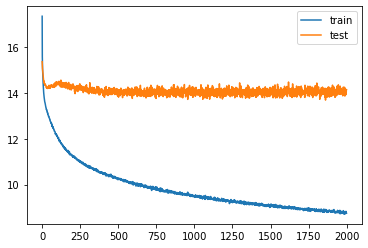

In [30]:
#really ugly code, sorry lol
path = "C:/Users/Matt/Dropbox/SnowComp/RunGraphs/converge" + "_" + \
    str(cdim1)+ "_" + str(cdim2)+ "_" +str(cdim3)+ "_" + str(kernel_sz)+ \
    "_" + str(dropout)+ "_" + str(ldim)+ "_" + str(epoch) +".png"

plt.plot(range(epoch+1), np.sqrt(train_loss), label ="train")
plt.plot(range(epoch+1), np.sqrt(test_loss), label ="test")
plt.legend()
plt.savefig(path)

## Things to check

1. Accuracy measures are right
2. Check missing value

### TODO:
- Add test set/cv
- Batchnorm?
- CNN benchmark